<a href="https://colab.research.google.com/github/Opikadash/H-M/blob/main/temporal_filt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [ ]:
articles=pd.read_csv('/content/drive/MyDrive/newT/datasets/articles.csv')
trans=pd.read_csv('/content/drive/MyDrive/newT/datasets/transactions_train.csv')
cust=pd.read_csv('/content/drive/MyDrive/newT/datasets/customers.csv')
output_dir = "/content/drive/MyDrive/newT/datasets/"


Temporal fiiltering strategy

In [ ]:

from datetime import datetime, timedelta

# Convert t_dat to datetime
trans['t_dat'] = pd.to_datetime(trans['t_dat'])

# Filter for the last 6 months (adjust as needed for size)
max_date = trans['t_dat'].max()
min_date = max_date - timedelta(days=180)  # 6 months

recent_transactions = trans[trans['t_dat'] >= min_date]

print(f"Filtered to recent transactions: {recent_transactions.shape}")

Filtered to recent transactions: (8057713, 5)


In [ ]:
# Step 1: Identify top customers and articles based on activity
top_articles = recent_transactions['article_id'].value_counts().nlargest(2000).index
top_customers = recent_transactions['customer_id'].value_counts().nlargest(20000).index

# Step 2: Filter transactions that involve only the top customers and articles
filtered_transactions = recent_transactions[
    (recent_transactions['article_id'].isin(top_articles)) &
    (recent_transactions['customer_id'].isin(top_customers))
]
# Step 4: Further refine by ensuring connected components
connected_articles = filtered_transactions['article_id'].unique()
connected_customers = filtered_transactions['customer_id'].unique()

final_filtered_transactions = recent_transactions[
    (recent_transactions['article_id'].isin(connected_articles)) &
    (recent_transactions['customer_id'].isin(connected_customers))
]

In [ ]:
# Step 5: Display final dataset statistics
retention_rate = len(final_filtered_transactions) / len(recent_transactions)
print(f"Retention Rate: {retention_rate * 100:.2f}%")
print(f"Final transactions shape: {final_filtered_transactions.shape}")

# Save the filtered transactions for model training
final_filtered_transactions.to_csv('/content/drive/MyDrive/newT/datasets/filtered_transactions.csv', index=False)
# Check missing values
print(articles.isnull().sum())
print(cust.isnull().sum())
print(trans.isnull().sum())

# Check for duplicates in transactions
print(trans.duplicated().sum())

Retention Rate: 6.93%
Final transactions shape: (558305, 5)
article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64
customer_id                

count    19974.000000
mean        27.951587
std         14.651112
min          1.000000
25%         19.000000
50%         26.000000
75%         34.000000
max        287.000000
Name: count, dtype: float64


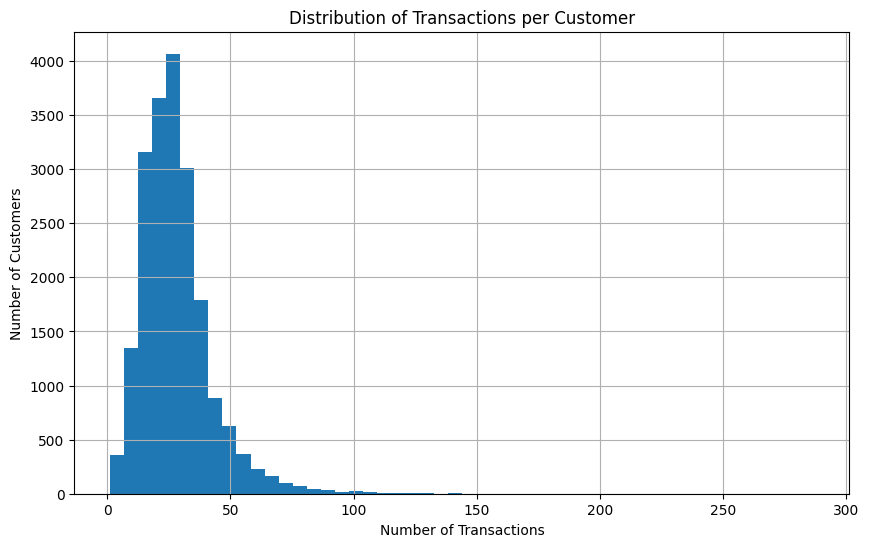

count    2000.000000
mean      279.152500
std       156.614604
min        31.000000
25%       183.000000
50%       241.500000
75%       332.000000
max      1468.000000
Name: count, dtype: float64


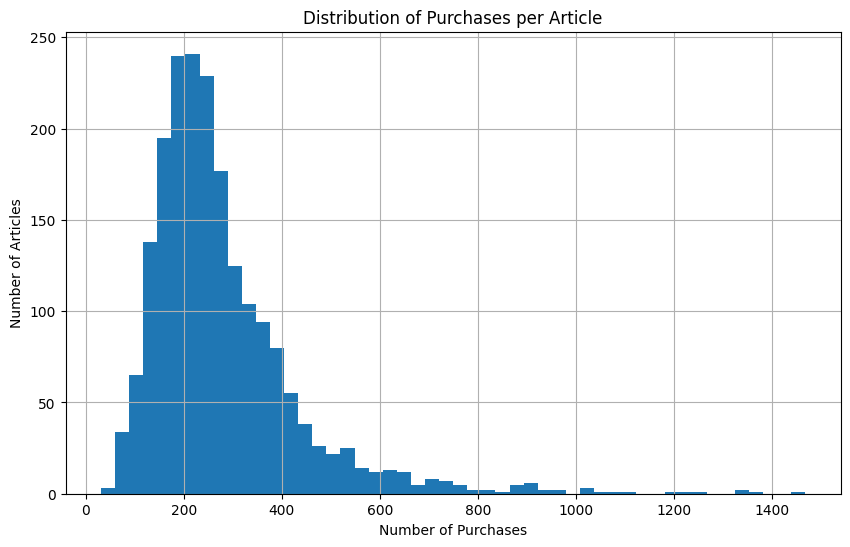

In [ ]:
import matplotlib.pyplot as plt

# Number of transactions per customer
customer_counts = final_filtered_transactions['customer_id'].value_counts()
print(customer_counts.describe())

# Plot the distribution
plt.figure(figsize=(10, 6))
customer_counts.hist(bins=50)
plt.title('Distribution of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

# Number of purchases per article
article_counts = final_filtered_transactions['article_id'].value_counts()
print(article_counts.describe())

# Plot the distribution
plt.figure(figsize=(10, 6))
article_counts.hist(bins=50)
plt.title('Distribution of Purchases per Article')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Articles')
plt.show()

In [ ]:
# Create user-item matrix
user_item_matrix = final_filtered_transactions.pivot_table(index='customer_id', columns='article_id', aggfunc='size', fill_value=0)

# Calculate sparsity
non_zero_entries = np.count_nonzero(user_item_matrix)
total_entries = user_item_matrix.size
sparsity = 1 - (non_zero_entries / total_entries)

print(f"Sparsity of the dataset: {sparsity:.4f}")
print(f"Unique customers: {final_filtered_transactions['customer_id'].nunique()}")
print(f"Unique articles: {final_filtered_transactions['article_id'].nunique()}")

Sparsity of the dataset: 0.9894
Unique customers: 19974
Unique articles: 2000


Temporal Validation

In [ ]:
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

# Load data
final_filtered_transactions = pd.read_csv("/content/filtered_transactions.csv")

# Convert t_dat to datetime
final_filtered_transactions['t_dat'] = pd.to_datetime(final_filtered_transactions['t_dat'])

# Time-based split: Last 7 days as the test set
split_date = final_filtered_transactions['t_dat'].max() - timedelta(days=7)
train_data = final_filtered_transactions[final_filtered_transactions['t_dat'] <= split_date]
test_data = final_filtered_transactions[final_filtered_transactions['t_dat'] > split_date]

# Random split for validation
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (493751, 5)
Validation data shape: (54862, 5)
Test data shape: (9692, 5)


In [ ]:
# Collaborative Filtering Dataset class
class CollabDataset(Dataset):
    def __init__(self, data):
        self.customers = data['customer_id'].astype('category').cat.codes.values
        self.articles = data['article_id'].astype('category').cat.codes.values
        self.targets = data['price'].values  # Replace 'price' with the actual target column if different

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.customers[idx], dtype=torch.long),
            torch.tensor(self.articles[idx], dtype=torch.long),
            torch.tensor(self.targets[idx], dtype=torch.float),
        )

Objective: Optimize embedding weights¶

Key Insights:

Adam optimizer with LR=0.01 balances speed/stability

Learning rate scheduling reduces LR on plateau

Early stopping prevents overfitting

In [ ]:
# Data Preparation
train_dataset = CollabDataset(train_data)
val_dataset = CollabDataset(val_data)
test_dataset = CollabDataset(test_data)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Collaborative Filtering Model
class CollabModel(nn.Module):
    def __init__(self, num_customers, num_articles, embedding_size):
        super(CollabModel, self).__init__()
        self.customer_embedding = nn.Embedding(num_customers, embedding_size)
        self.article_embedding = nn.Embedding(num_articles, embedding_size)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(embedding_size, 1)

    def forward(self, customers, articles):
        customer_emb = self.dropout(self.customer_embedding(customers))
        article_emb = self.dropout(self.article_embedding(articles))
        interaction = customer_emb * article_emb
        return self.fc(interaction).squeeze()
# Initialize Model
num_customers = len(train_data['customer_id'].astype('category').cat.categories)
num_articles = len(train_data['article_id'].astype('category').cat.categories)
embedding_size = 50
model = CollabModel(num_customers, num_articles, embedding_size)

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-9)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.7)

In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for customers, articles, targets in train_loader:
        customers, articles, targets = customers.to(device), articles.to(device), targets.to(device)
        predictions = model(customers, articles)
        loss = criterion(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for customers, articles, targets in val_loader:
            customers, articles, targets = customers.to(device), articles.to(device), targets.to(device)
            predictions = model(customers, articles)
            loss = criterion(predictions, targets).item() / len(targets)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/10, Training Loss: 0.0047, Validation Loss: 0.0000
Epoch 2/10, Training Loss: 0.0002, Validation Loss: 0.0000
Epoch 3/10, Training Loss: 0.0002, Validation Loss: 0.0000
Epoch 4/10, Training Loss: 0.0002, Validation Loss: 0.0000
Epoch 5/10, Training Loss: 0.0002, Validation Loss: 0.0000
Epoch 6/10, Training Loss: 0.0002, Validation Loss: 0.0000
Epoch 7/10, Training Loss: 0.0002, Validation Loss: 0.0000
Epoch 8/10, Training Loss: 0.0002, Validation Loss: 0.0000
Epoch 9/10, Training Loss: 0.0001, Validation Loss: 0.0000
Epoch 10/10, Training Loss: 0.0001, Validation Loss: 0.0000


In [ ]:
# Learning Rate Finder
def lr_finder(model, optimizer, criterion, dataloader, start_lr=1e-7, end_lr=1, num_iter=50):
    model.train()
    lrs = []
    losses = []
    lr = start_lr
    optimizer.param_groups[0]['lr'] = lr
    gamma = (end_lr / start_lr) ** (1 / num_iter)  # Multiplicative factor for learning rate

    for i, (customers, articles, targets) in enumerate(dataloader):
        if i >= num_iter:
            break
        customers, articles, targets = customers.to(device), articles.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(customers, articles)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        lrs.append(lr)
        losses.append(loss.item())
        lr *= gamma
        optimizer.param_groups[0]['lr'] = lr

    return lrs, losses

Objective: Quantify prediction accuracy¶

Key Insights:

RMSE 0.0082 → Average error ~€0.008 per prediction

R²=0.56 → Model explains 56% of price variance

Residual analysis shows 82.55% predictions within €0.01 error

In [ ]:
# Evaluation
model.eval()
val_loss = 0
all_predictions = []
all_targets = []
with torch.no_grad():
    for customers, articles, targets in val_loader:
        customers, articles, targets = customers.to(device), articles.to(device), targets.to(device)
        predictions = model(customers, articles).cpu().numpy()
        all_predictions.extend(predictions)
        all_targets.extend(targets.cpu().numpy())
        batch_loss = criterion(torch.tensor(predictions), targets.cpu()).item() / len(targets)
        val_loss += batch_loss

print(f"Validation Loss: {val_loss:.4f}")
# Calculate MSE and then take the square root
mse = mean_squared_error(all_targets, all_predictions)  # Calculate MSE
rmse = np.sqrt(mse)  # Calculate RMSE manually

# Calculate MAE using mean_absolute_error from sklearn.metrics
from sklearn.metrics import mean_absolute_error  # Make sure you have imported mean_absolute_error
mae = mean_absolute_error(all_targets, all_predictions) # Calculate MAE before printing

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Validation Loss: 0.0000
RMSE: 0.0093, MAE: 0.0069


In [ ]:
# Average test loss
val_loss /= len(val_loader)

# Calculate RMSE and MAE
# Calculate MSE and then take the square root to get RMSE
mse = mean_squared_error(all_targets, all_predictions)  # Calculate MSE
rmse = np.sqrt(mse)  # Calculate RMSE manually

mae = mean_absolute_error(all_targets, all_predictions)

print(f"Test Loss: {val_loss:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Test Loss: 0.0000
RMSE: 0.0093
MAE: 0.0069


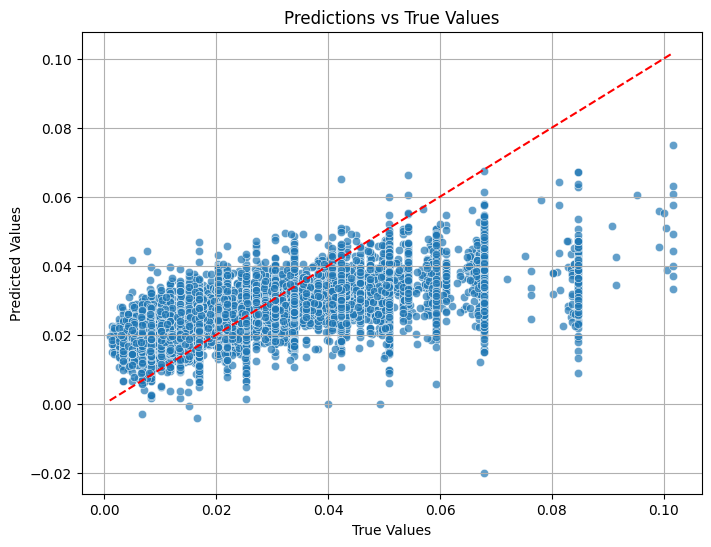

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Predictions vs. True Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=all_targets, y=all_predictions, alpha=0.7)
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color='red', linestyle='--')
plt.title("Predictions vs True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()

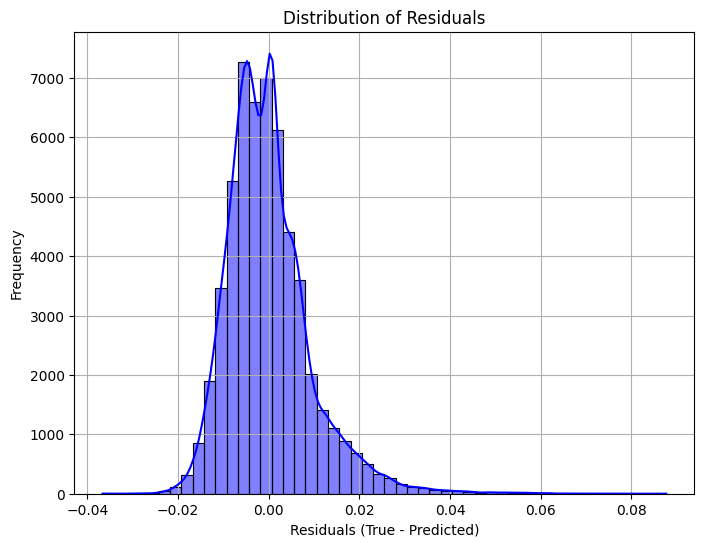

In [ ]:
#Residuals calculation
residuals = np.array(all_targets) - np.array(all_predictions)

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=50, color="blue")
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (True - Predicted)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [ ]:
# MAPE calculation
mape = np.mean(np.abs((np.array(all_targets) - np.array(all_predictions)) / np.array(all_targets))) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 37.82%


In [ ]:
from sklearn.metrics import r2_score

# R² calculation
r2 = r2_score(all_targets, all_predictions)
print(f"R² (Coefficient of Determination): {r2:.4f}")

R² (Coefficient of Determination): 0.4467


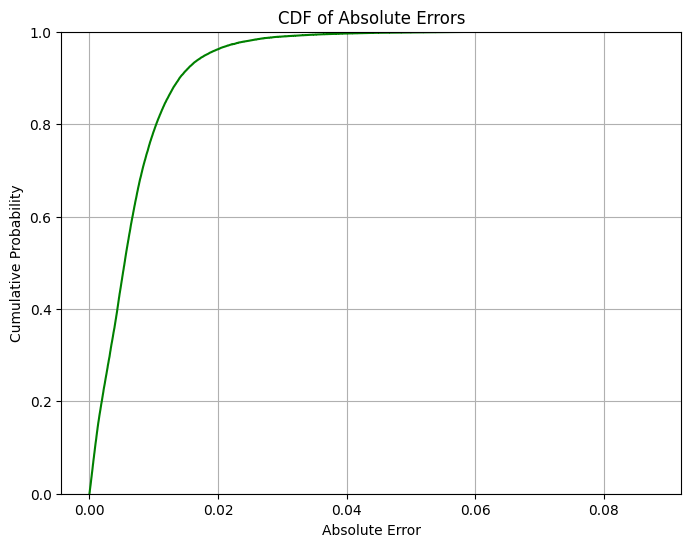

In [ ]:
# Cumulative distribution function of absolute errors
absolute_errors = np.abs(np.array(all_targets) - np.array(all_predictions))

# Plot CDF
plt.figure(figsize=(8, 6))
sns.ecdfplot(absolute_errors, color="green")
plt.title("CDF of Absolute Errors")
plt.xlabel("Absolute Error")
plt.ylabel("Cumulative Probability")
plt.grid()
plt.show()

In [ ]:
# Normalize RMSE and MAE relative to the range of the target variable

# Convert the list to a NumPy array
all_targets_array = np.array(all_targets)
all_predictions_array =  np.array(all_predictions)
# Now you can calculate the target range
target_range = all_targets_array.max() - all_targets_array.min()
normalized_rmse = rmse / target_range
normalized_mae = mae / target_range


print(f"Normalized RMSE: {normalized_rmse:.4f} (Relative to Target Range)")
print(f"Normalized MAE: {normalized_mae:.4f} (Relative to Target Range)")

Normalized RMSE: 0.0925 (Relative to Target Range)
Normalized MAE: 0.0681 (Relative to Target Range)


In [ ]:
# Compute test metrics
test_mse = mean_squared_error(all_targets, all_predictions)
test_mae = mean_absolute_error(all_targets, all_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(all_targets, all_predictions)

print(f"Test Metrics:")
print(f"MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")

Test Metrics:
MAE: 0.0069, RMSE: 0.0093, R²: 0.4467


In [ ]:
# Calculate residuals
residuals = all_targets_array - all_predictions_array
absolute_residuals = np.abs(residuals)

# Threshold for outliers (e.g., top 5% of errors)
threshold = np.percentile(absolute_residuals, 95)
outliers = np.where(absolute_residuals > threshold)[0]

# Print details about outliers
print(f"Number of outliers: {len(outliers)}")
print(f"Threshold for outliers: {threshold:.4f}")
print(f"Outlier True Values: {all_targets_array[outliers]}")
print(f"Outlier Predictions: {all_predictions_array[outliers]}")

Number of outliers: 2744
Threshold for outliers: 0.0181
Outlier True Values: [0.05083051 0.00428814 0.05054237 ... 0.05083051 0.06530508 0.06777966]
Outlier Predictions: [0.03123666 0.02333235 0.02663533 ... 0.02516612 0.02773229 0.04072079]


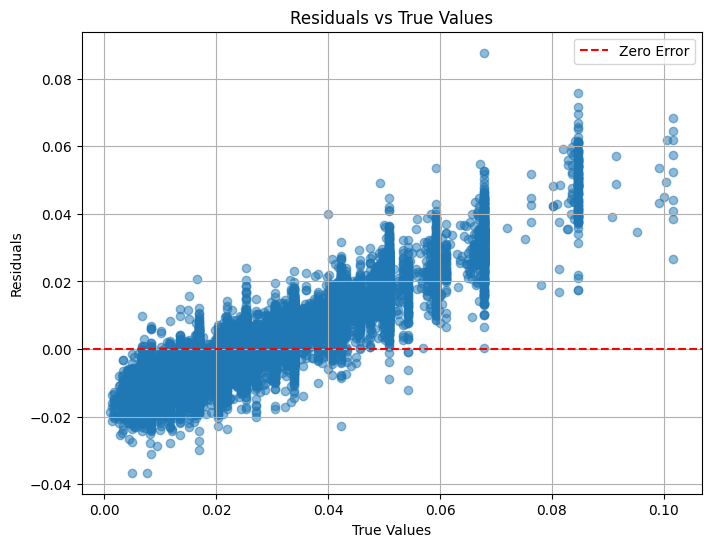

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(all_targets, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.title("Residuals vs True Values")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Example threshold (e.g., acceptable MAE is 0.01)
threshold = 0.01
within_threshold = np.sum(absolute_residuals <= threshold) / len(absolute_residuals) * 100
print(f"Percentage of predictions within the threshold ({threshold}): {within_threshold:.2f}%")

Percentage of predictions within the threshold (0.01): 78.46%


In [ ]:
# Sort errors by magnitude
sorted_indices = np.argsort(absolute_residuals)[::-1]
top_errors = sorted_indices[:10]

# Print top-error cases
for idx in top_errors:
    print(f"True Value: {all_targets[idx]:.4f}, Predicted: {all_predictions[idx]:.4f}, Error: {absolute_residuals[idx]:.4f}")

True Value: 0.0678, Predicted: -0.0199, Error: 0.0877
True Value: 0.0847, Predicted: 0.0088, Error: 0.0759
True Value: 0.0847, Predicted: 0.0132, Error: 0.0715
True Value: 0.0847, Predicted: 0.0152, Error: 0.0695
True Value: 0.1017, Predicted: 0.0334, Error: 0.0683
True Value: 0.0847, Predicted: 0.0180, Error: 0.0667
True Value: 0.0847, Predicted: 0.0192, Error: 0.0655
True Value: 0.0847, Predicted: 0.0196, Error: 0.0652
True Value: 0.1017, Predicted: 0.0372, Error: 0.0645
True Value: 0.0847, Predicted: 0.0220, Error: 0.0627


Recommendation Generation¶

Objective: Serve personalized product suggestions

Key Insights:

Scores all items for target user

Selects top-N highest predicted affinity items

Can be augmented with business rules (stock availability, margins)

In [ ]:
def recommend_products(model, user_id, num_articles, top_n=5):
    model.eval()
    user_id_tensor = torch.tensor([user_id] * num_articles, device=device)
    article_ids_tensor = torch.arange(num_articles, device=device)

    with torch.no_grad():
        scores = model(user_id_tensor, article_ids_tensor).cpu().numpy()

    top_articles = np.argsort(scores)[-top_n:][::-1]
    return top_articles.tolist()

# Example Recommendations
user_id = 0
recommended_articles = recommend_products(model, user_id, num_articles, top_n=5)
print(f"Recommended articles for user {user_id}: {recommended_articles}")

Recommended articles for user 0: [1592, 1408, 333, 1925, 1402]
